Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

In [1]:
import tensorflow as tf
import PIL.Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import functools
import IPython.display as display

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams["axes.grid"] = False

In [4]:
def tensor_to_image(tensor):
    tensor = tensor*225
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [5]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

In [6]:
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


Define a function to load an image and limit its maximum dimension to 512 pixels.

In [7]:
def load_img(path_to_image):
    max_dims = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dims/long_dim
    
    new_shape = tf.cast(shape*scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [8]:
def img_show(image, title = None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis = 0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

In [9]:
content_img = load_img(content_path)

In [40]:
style_img = load_img(style_path)

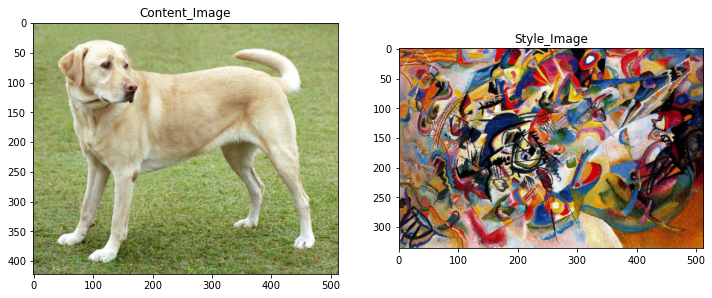

In [11]:
plt.subplot(1, 2, 1)
img_show(content_img, 'Content_Image')

plt.subplot(1, 2, 2)
img_show(style_img, 'Style_Image')

In [12]:
type(content_img)

tensorflow.python.framework.ops.EagerTensor

In [13]:
content_img.shape

TensorShape([1, 422, 512, 3])

In [14]:
style_img.shape

TensorShape([1, 336, 512, 3])

Fast Style Transfer using TF-Hub
This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the TensorFlow Hub module does:

In [15]:
import tensorflow_hub as hub

In [16]:
hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1")

In [17]:
stylized_img = hub_model(tf.constant(content_img), tf.constant(style_img))[0]

In [18]:
stylized_img.shape

TensorShape([1, 424, 512, 3])

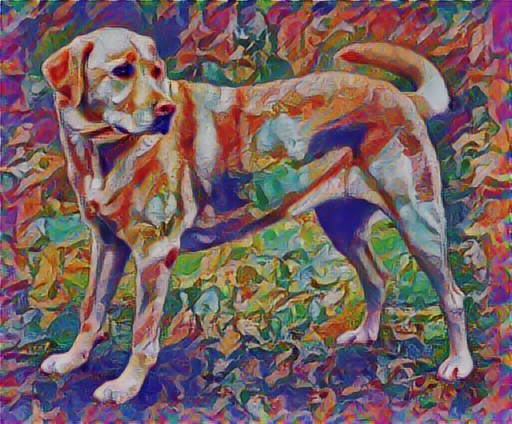

In [19]:
tensor_to_image(stylized_img)

In [20]:
content_img = load_img("C:/Users/Gaurav Rai/Buntu.jpg")

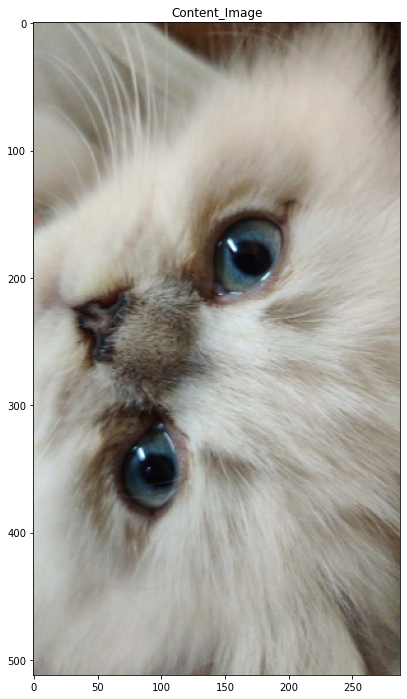

In [21]:
img_show(content_img, 'Content_Image')

In [22]:
stylized_img2 = hub_model(tf.constant(content_img), tf.constant(style_img))[0]

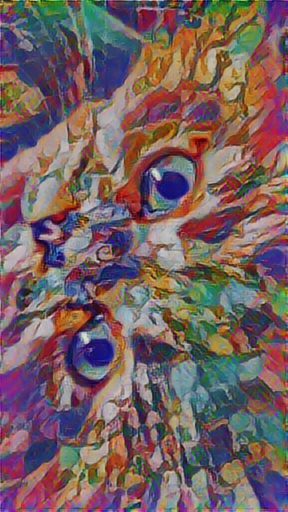

In [23]:
tensor_to_image(stylized_img2)

Define content and style representations
Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [24]:
x = tf.keras.applications.vgg19.preprocess_input(content_img*255)

In [31]:
x.shape

TensorShape([1, 224, 224, 3])

In [25]:
x = tf.image.resize(x, (224, 224))

In [32]:
x.shape

TensorShape([1, 224, 224, 3])

In [26]:
vgg = tf.keras.applications.VGG19(include_top = True, weights = 'imagenet')

In [28]:
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [30]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 1us/step


[('Persian_cat', 0.9813027),
 ('Angora', 0.010598084),
 ('lynx', 0.0047557484),
 ('Siamese_cat', 0.0006656623),
 ('Pomeranian', 0.00035640635)]

Along the processing hierarchy of the network, the input image is transformed into representations that increasingly care about the "actual content of the image" compared to its detailed pixel values. We therefore refer to the feature responses in higher layers of the network as the content representation.

To obtain a representation of the style of an input image, we use "Correlations between the differen t filter responses" over the spatial extent of the feature maps. We obtain a stationary, multi-scale representation of the input image, which captures its textual information but not the global arrangement.

In [33]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 25s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [34]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [36]:
num_style_layers

5

Intermediate layers for style and content
So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

In [37]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [38]:
style_extractor = vgg_layers(style_layers)

In [42]:
style_outputs = style_extractor(style_img*255)

For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [43]:
#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.137
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2537
  mean:  59.179478



The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

In [44]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

Einsum allows defining Tensors by defining their element-wise computation. This computation is defined by equation, a shorthand form based on Einstein summation.

In [45]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [46]:
extractor = StyleContentModel(style_layers, content_layers)

In [50]:
results = extractor(tf.constant(content_img))

In [51]:
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.008551212
    max:  34876.855
    mean:  160.5127

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  30415.865
    mean:  5093.0747

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  158721.31
    mean:  4698.587

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.07435624
    max:  1933885.5
    mean:  93147.95

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  59308.18
    mean:  878.4079

Contents:
   block5_conv2
    shape:  (1, 32, 18, 512)
    min:  0.0
    max:  1076.5416
    mean:  10.937073


With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [52]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

Define a tf.Variable to contain the image to optimize. To make this quick, initialize it with the content image (the tf.Variable must be the same shape as the content image):

In [54]:
image = tf.Variable(content_img)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [56]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [57]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [59]:
style_weight=1e-2
content_weight=1e4

In [62]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [63]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

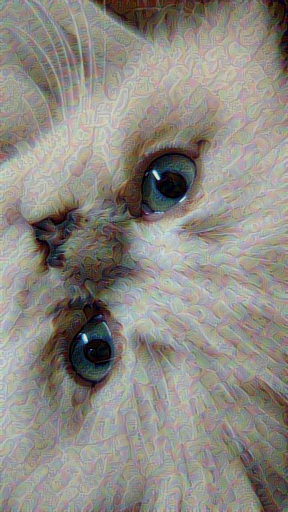

In [64]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

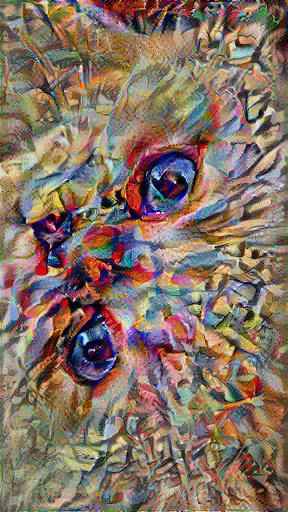

Train step: 1000
Total time: 1683.2


In [65]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))